**Case study: Bulk Deconvolution of synthetic bulk RNA samples with a human embryonic single-cell
reference profile**

This notebook is intended to illustrate a bulk deconvolution pipeline using AutoGeneS.
Here, signle-cell data set of human embryonic stem cells (Chu et al. 2016) is used as reference data for signature learning. 
The synthetic bulk RNA samples were generated by summing the sorted bulk RNA-seq read counts of the same tissue.

The deconvolution results are finally validated using the right proportions used for generating synthetic bulks.

The notebook takes approximately 8 minutes to run on a single core with sufficient RAM. 

# Loading the libraries

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import autogenes as ag

from sklearn.svm import NuSVR
import pickle

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Reading in the inputs

The Chu et al. data set was retrieved from the Gene Expression Omnibus (GEO) via the ID GSE75748. 
The following code expects to read the single cell data from folder "data" and bulk RNA samples and their proportions from folder "bulks".

The results are reproducible on a single machine but can slightly be different depending on  numpy and python versions. The current results are generated using the following packages:
* autogenes        1.0
* cachetools        4.0.0
* deap        1.3.1
* dill        0.3.1.1
* matplotlib        3.1.2
* numpy        1.16.4
* pandas        0.24.2
* scanpy        1.4.4.post1
* scipy        1.3.0
* seaborn        0.9.0
* Python 3.6.4 :: Anaconda, Inc.

In [2]:
#read single-cell data
file = './data/GSE75748_sc_cell_type_ec.csv'
adata = sc.read(file, cache=True).transpose()
adata

AnnData object with n_obs × n_vars = 1018 × 19097 

In [3]:
#read 100 synthetic bulks generated by summing single cells
#the bulks are normalized to counts_per_cell_after=1e4
#proportions are only required for validation
path = './bulks/'
data_bulk_raw = pd.read_csv(path+'bulks.csv',delimiter='\t', index_col=0)
proportions = pd.read_csv(path + "proportions.csv", sep='\t', index_col=0)

# Preprocessing single-cell data

In [4]:
#normalizing and selecting 4000 hihgly variable genes for optimization
#we use log normalized data for selecting hihgly variable genes and visualization
adata_norm = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True) 
adata_log = sc.pp.log1p(adata_norm, copy=True) 
sc.pp.highly_variable_genes(adata_log, flavor='cell_ranger', n_top_genes=4000)
adata_proc = adata_norm[:, adata_log.var[adata_log.var['highly_variable']==True].index]
adata_proc

View of AnnData object with n_obs × n_vars = 1018 × 4000 
    obs: 'n_counts'

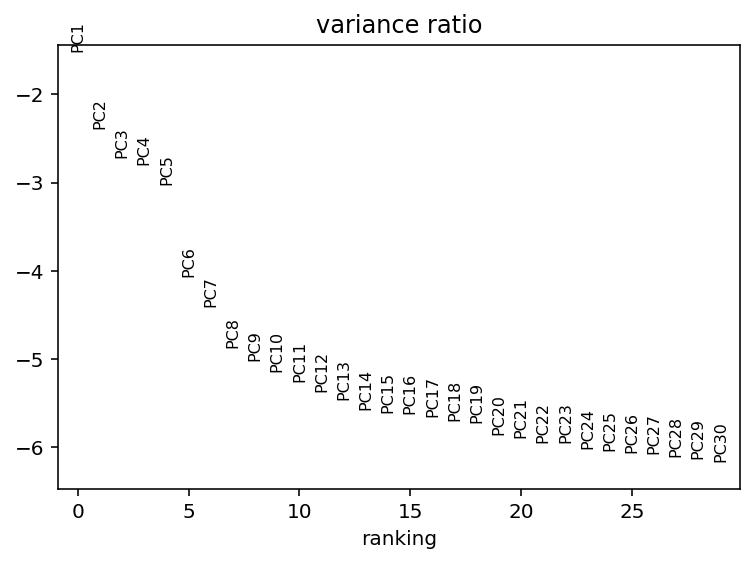

In [5]:
sc.pp.pca(adata_log, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_log, log=True)

In [6]:
adata_log.obs['cells'] = [x.split('_', 1)[0] for x in adata_log.obs_names]

... storing 'cells' as categorical


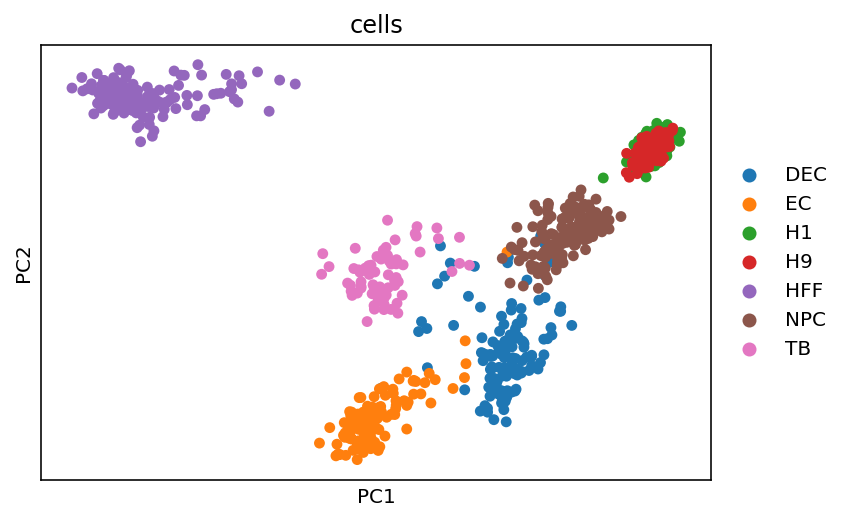

In [7]:
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata_log, color='cells')

In [8]:
#remove H9 because of high correlation with H1
adata_log = adata_log[adata_log.obs[adata_log.obs['cells'] != 'H9'].index]

In [9]:
#filter cells in normalized data
adata_proc = adata_proc[adata_log.obs_names]

In [10]:
#calculating the centroids of cell types
clusters = np.array(['H1', 'DEC', 'EC', 'HFF', 'NPC', 'TB'])
sc_mean = pd.DataFrame(index=adata_proc.var_names,columns=clusters)
for cluster in clusters:
    cells = [x for x in adata_proc.obs_names if x.startswith(cluster)]
    sc_part = adata_proc[cells,:].X.T
    sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)
    
centroids_sc_hv = sc_mean
centroids_sc_hv.shape

(4000, 6)

# AutoGeneS

### Optimization

In [11]:
ag.init(centroids_sc_hv.T)
ag.optimize(ngen=5000,seed=0,nfeatures=400,mode='fixed',offspring_size=100,verbose=False)

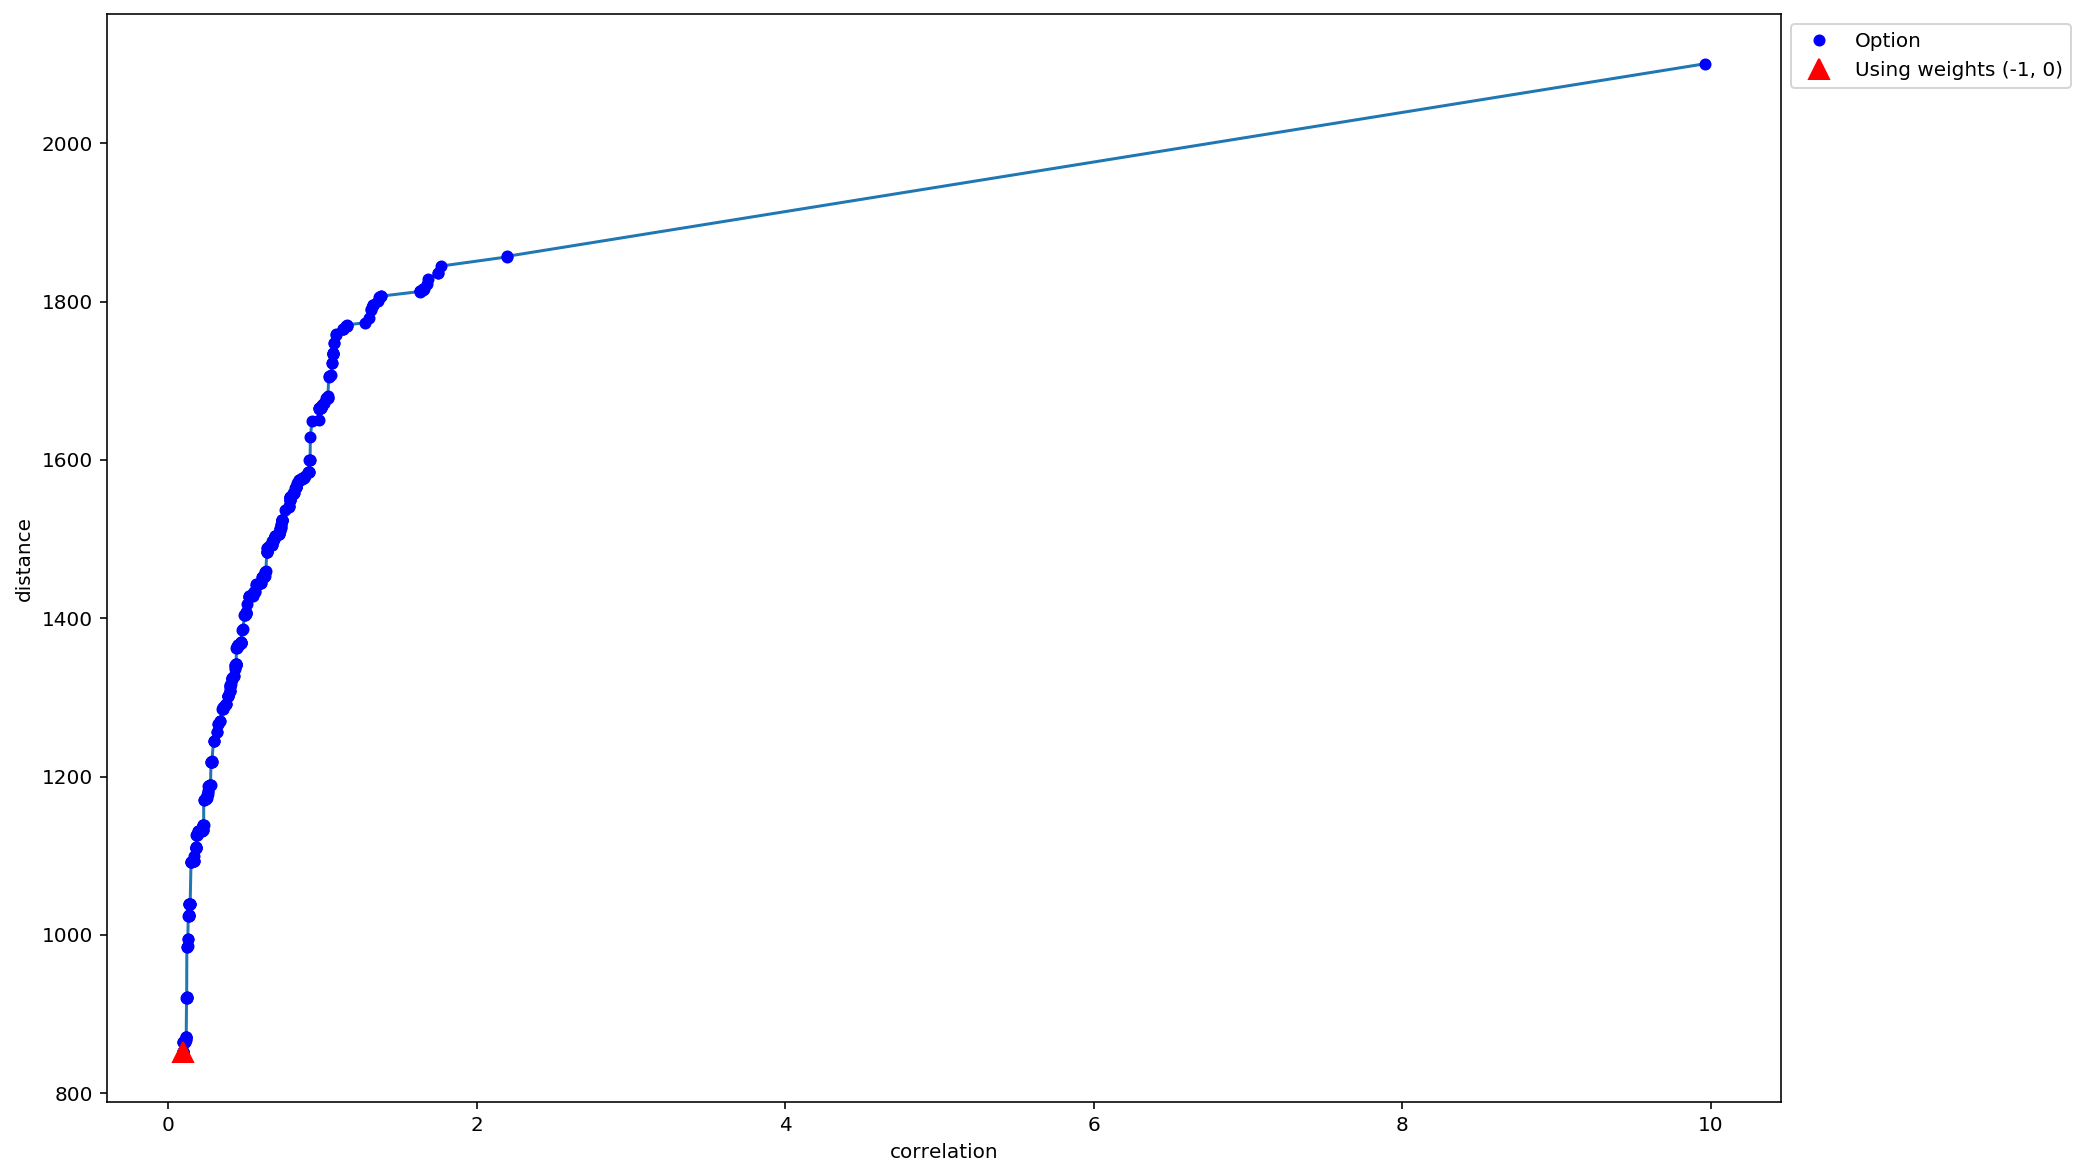

In [12]:
ag.plot(weights=(-1,0))

In [13]:
index = ag.select(index=0)

In [14]:
#filter marker genes in the bulk samples
centroids_sc_pareto = centroids_sc_hv[index]
#data_bulk_proc = data_bulk_raw.loc[centroids_sc_pareto.index,:]

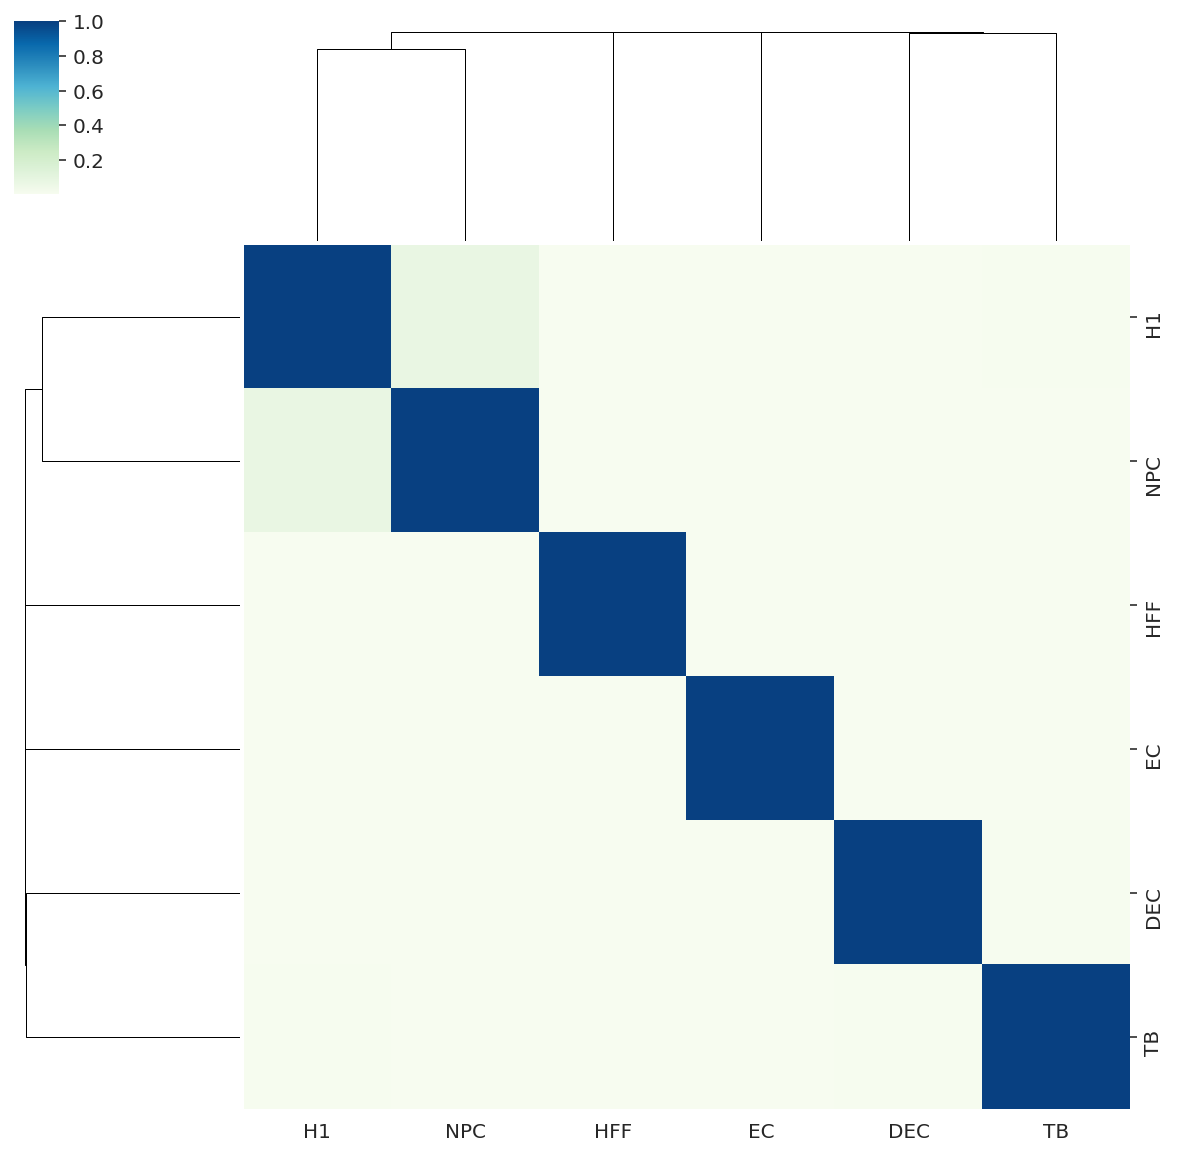

In [15]:
#Correlation matrix
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

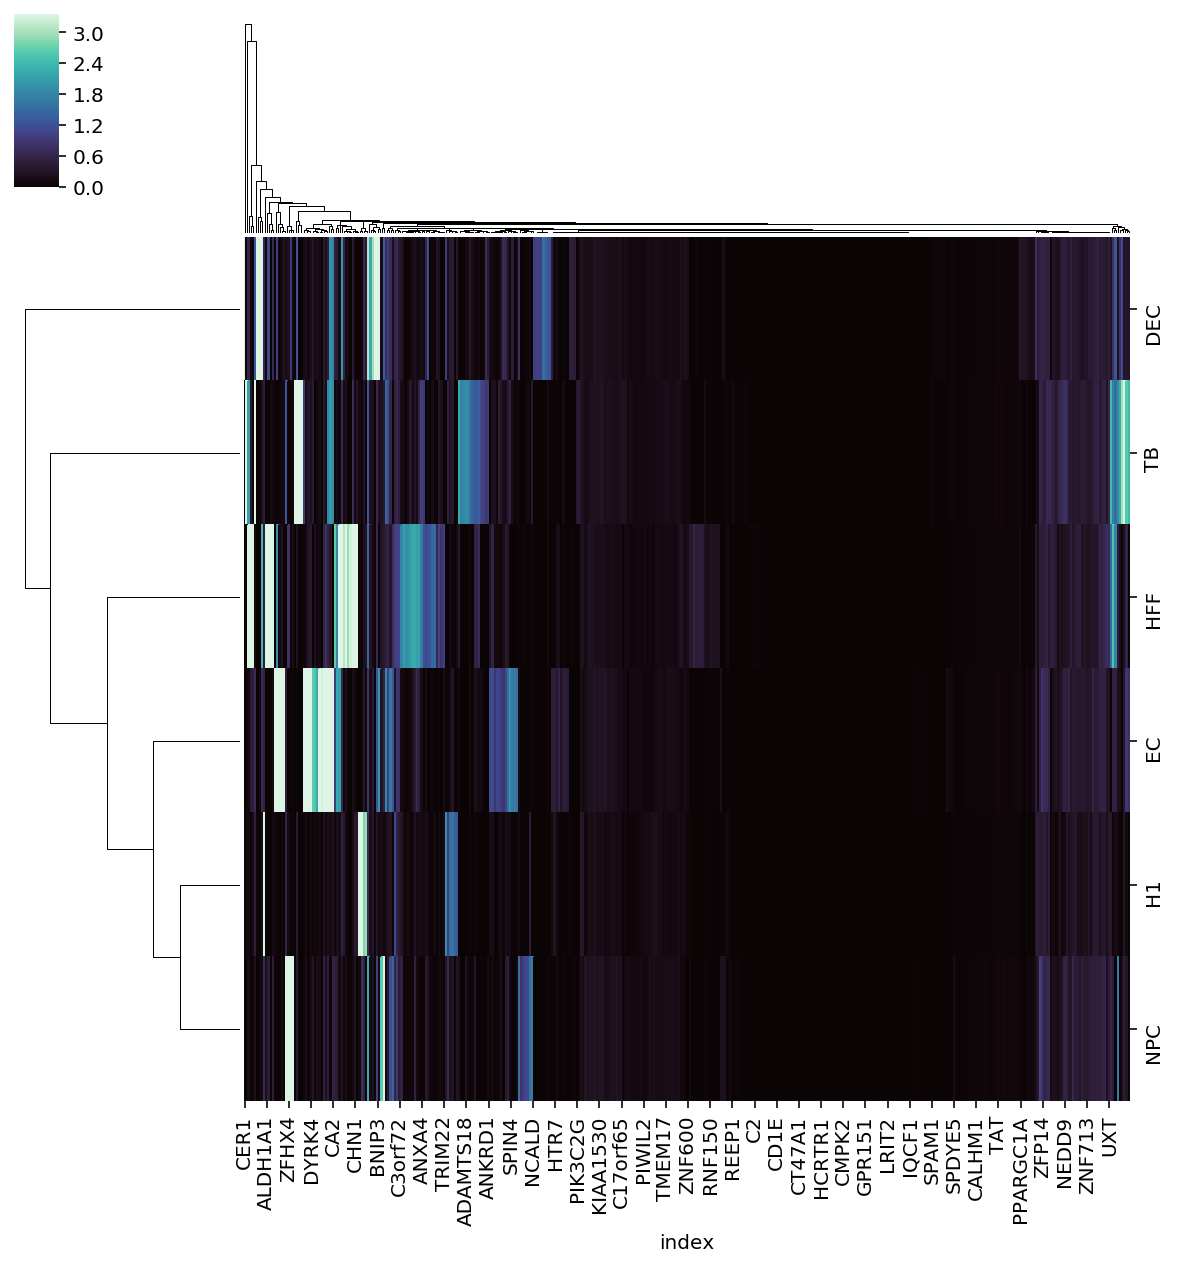

In [16]:
#marker genes
import seaborn as sns
subTypes = pd.DataFrame
subTypes = centroids_sc_pareto.columns
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique(), type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True)

## Regression

In [17]:
coef_nusvr = ag.deconvolve(data_bulk_raw.T, model='nusvr')
coef_nnls = ag.deconvolve(data_bulk_raw.T, model='nnls')

In [18]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
    return data_copy

In [19]:
proportions_NuSVR = normalize_proportions(pd.DataFrame(data=coef_nusvr,columns=clusters,index=data_bulk_raw.columns), copy = False)
proportions_nnls = normalize_proportions(pd.DataFrame(data=coef_nnls,columns=clusters,index=data_bulk_raw.columns), copy = False)

# Validation and plotting the results

In [20]:
def plot_(x,y,title):
    s,i,r,p,e = sci.stats.linregress(x,y)
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot(111)
    ax.scatter(x, y, color = 'black',s=5)
    
    x = np.linspace(np.min(x), np.max(x), 1000)
    y=x*s+i
    ax.plot(x,y)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.title(title)
    ax.text(0.8, 0.1,'p='+str(p), ha='center', va='center', transform=ax.transAxes)
    return

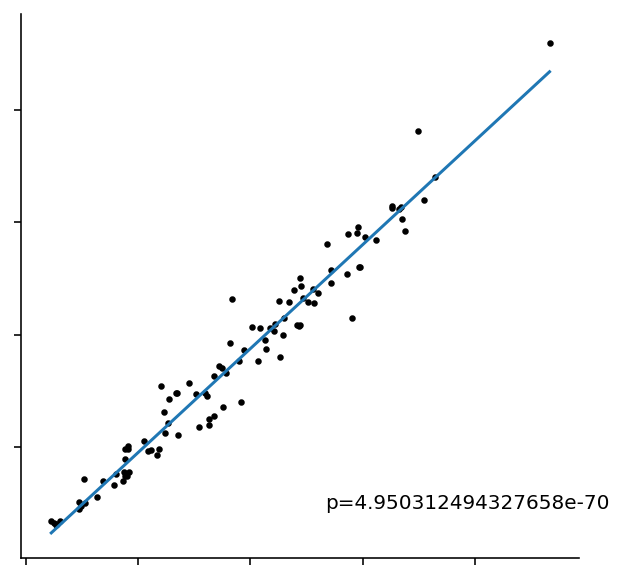

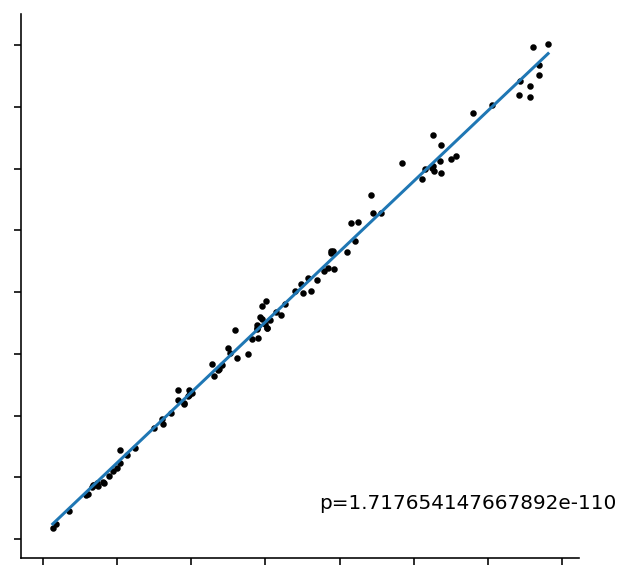

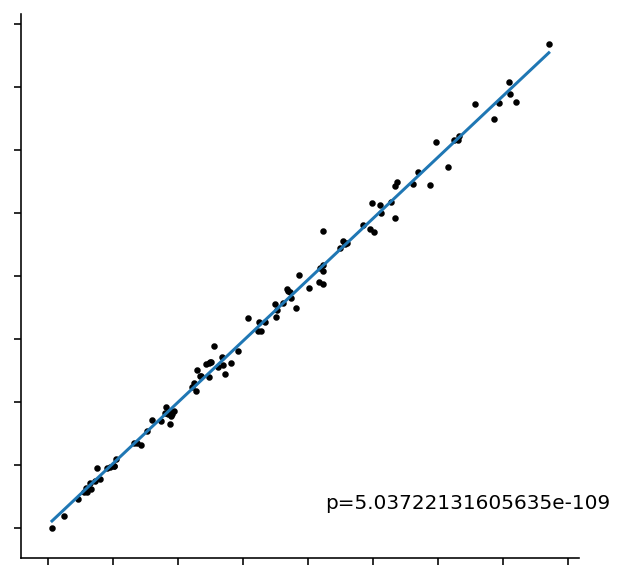

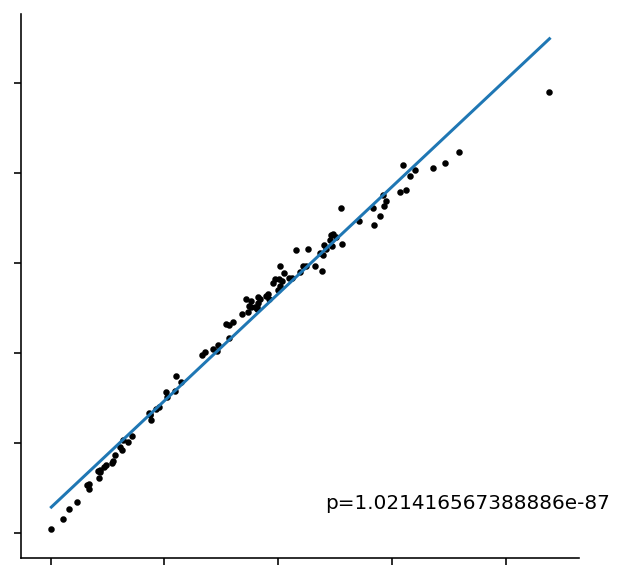

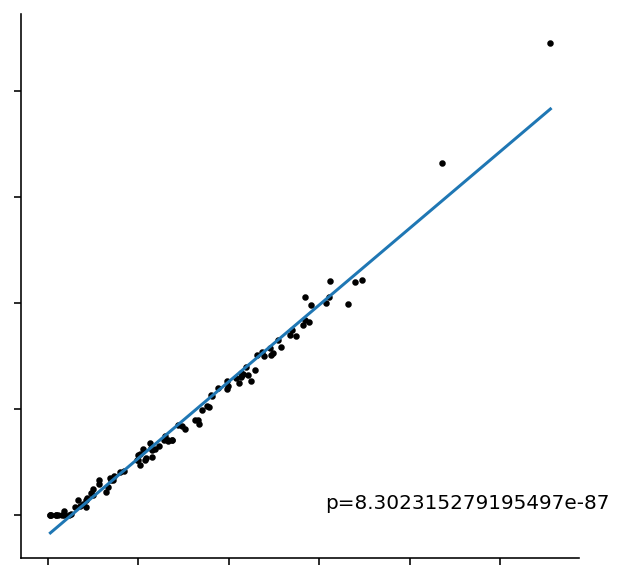

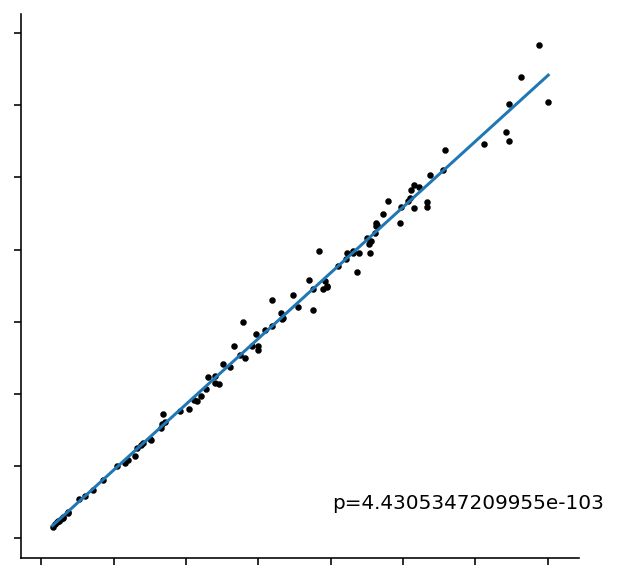

In [21]:
#Comparing real and estimated proportions using NuSVR regression
for c in proportions.columns:
    t = c
    plot_(proportions[c],proportions_NuSVR[c],t[5:])

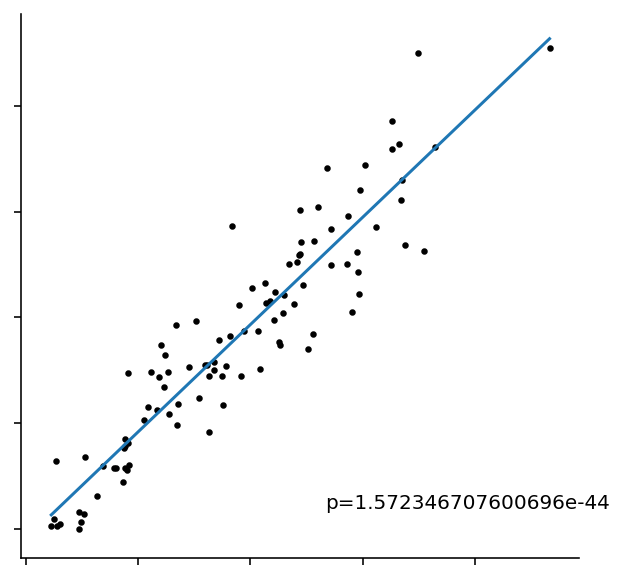

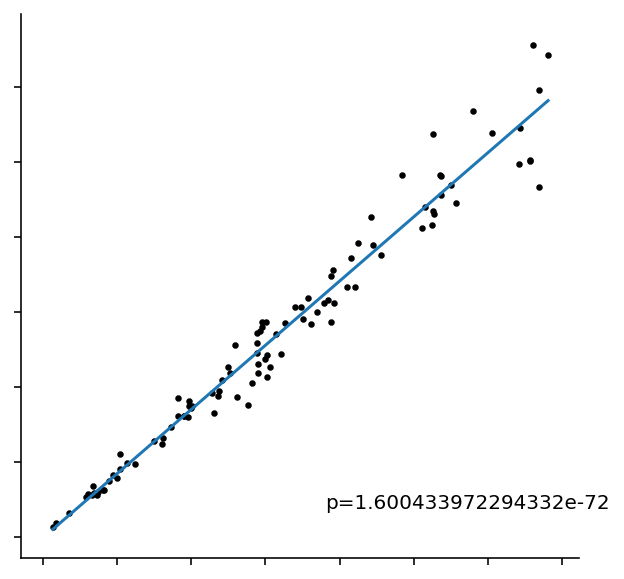

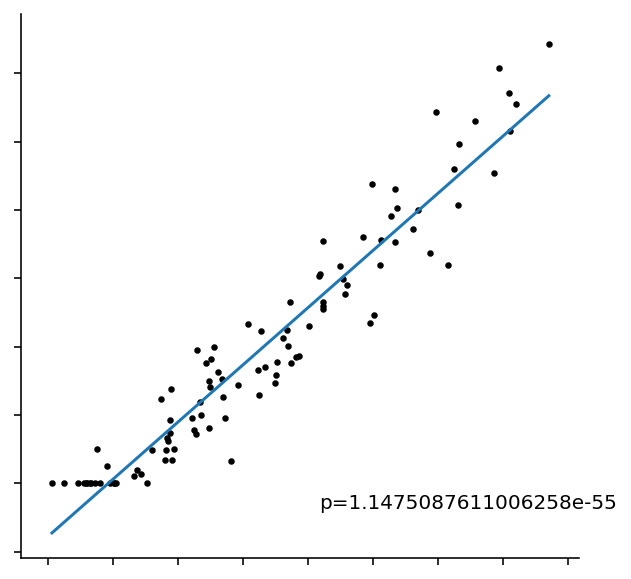

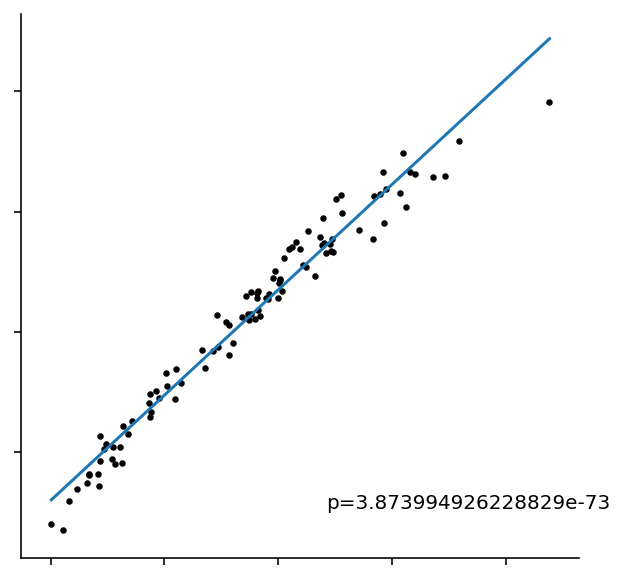

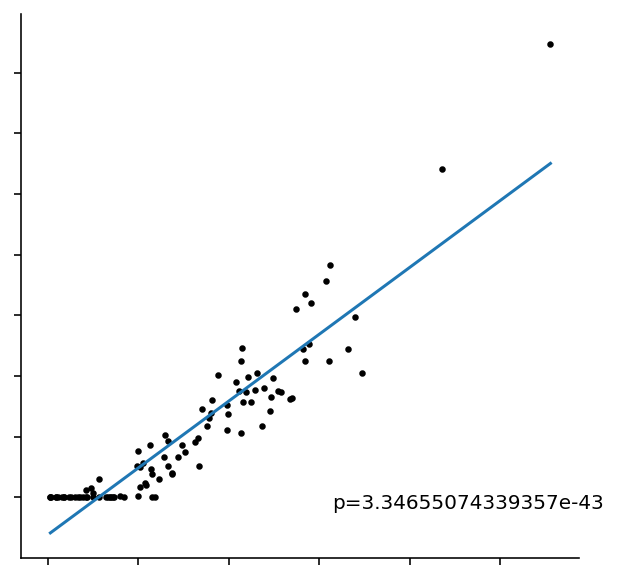

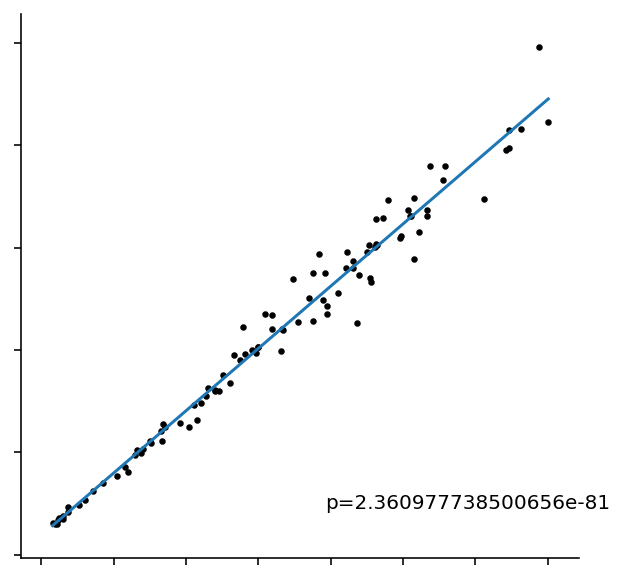

In [22]:
#Comparing real and estimated proportions using nnls
for c in proportions.columns:
    t = c
    plot_(proportions[c],proportions_nnls[c],t[5:])